In [8]:
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from minio import Minio
from sklearn.cluster import KMeans

mpl.style.use("fivethirtyeight")
mpl.rcParams["figure.figsize"] = (15, 8)
mpl.rcParams["figure.dpi"] = 50
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25

In [2]:
# --------------------------------------------------------------
# Connecting to Data Lake
# --------------------------------------------------------------

client = Minio(
    "localhost:9000", access_key="minioadmin", secret_key="minioadmin", secure=False
)

In [5]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle("../data/interim/01_cleaned_data.pkl")

df.head(3)

,department,salary,averageMonthlyHours,projectCount,satisfaction,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266,2,38.0,53.0,3,0,1
1,sales,medium,252,5,80.0,86.0,6,0,1
2,sales,medium,289,7,11.0,88.0,4,0,1


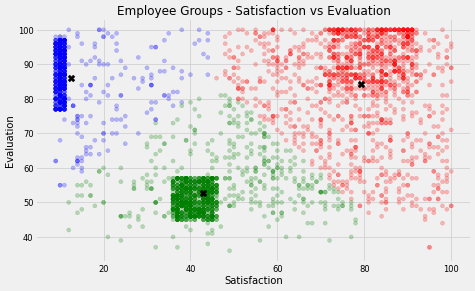

In [9]:
# --------------------------------------------------------------
# Creating clusters using KMeans
# --------------------------------------------------------------

# Initialize the KMeans object with 3 clusters, using a specific random state for
# reproducibility, and performing a maximum of 10 initialization attempts.
kmeans = KMeans(n_clusters=3, random_state=2, n_init=10)

# Defining the data set.
# Selecting the data of employees who left the company and the columns "satisfaction" and "evaluation".
df_turnover = df[df.turnover == 1][["satisfaction", "evaluation"]]

# Fit the KMeans model to the data.
kmeans.fit(df_turnover)

# Assign colors to data points based on cluster labels.
kmeans_colors = [
    "green" if c == 0 else "red" if c == 1 else "blue" for c in kmeans.labels_
]

# Create a scatter plot to visualize the data points and clusters.
fig = plt.figure(figsize=(10, 6))
plt.scatter(
    x="satisfaction", y="evaluation", data=df_turnover, alpha=0.25, color=kmeans_colors
)

# Add labels to the axes.
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")

# Plot cluster centers as black X markers.
plt.scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    color="black",
    marker="X",
    s=100,
)

# Add title and display the plot.
plt.title("Employee Groups - Satisfaction vs Evaluation")
plt.show()

#### K-Means Clusters
***
**Cluster 0 (Green):** Hardworking and satisfied employees.

**Cluster 1 (Red):** Poor-performing and dissatisfied employees.

**Cluster 2 (Blue):** Hardworking but unhappy employees.

In [13]:
# --------------------------------------------------------------
# Transfering to Data Lake
# --------------------------------------------------------------

# Persisting the cluster object for the disk
joblib.dump(kmeans, "cluster.joblib")

# Connecting to Data Lake
client = Minio(
    "localhost:9000", access_key="minioadmin", secret_key="minioadmin", secure=False
)

# Transferring the file to Data Lake
client.fput_object("curated", "cluster.joblib", "cluster.joblib")


**Códigos orignais:** [build_features.py](../src/features/build_features.py)

**Next step:** [04_train_model.ipynb](04_train_model.ipynb)